## Aufgabe 12.4 – Klassifikationsmodell für defekte Flaschen

Ziel dieser Aufgabe ist es, ein Klassifikationsmodell zu entwickeln, welches defekte Flaschen anhand der Schwingungsdaten beim Vereinzeln (`drop_oscillation`) erkennt.  
Dabei werden sowohl zeitbasierte als auch frequenzbasierte Merkmale (mittels Fourier-Transformation) extrahiert bzw. berechnet und mit verschiedenen Modellen getestet.

Die Labels (`is_cracked`) klassifizieren, ob eine Flasche defekt ist. Die Datenbasis ist stark unausgewogen, daher wurde ein Unter-Sampling der Mehrheitsklasse (nicht defekt) im Trainingsset durchgeführt.

### Verwendete Bibliotheken

Folgende Bibliotheken wurden für die Datenverarbeitung, Modellierung und Visualisierung verwendet:

- `pandas` für Datenmanipulation und CSV-Import
- `numpy` für numerische Berechnungen und Signalverarbeitung
- `matplotlib` und `seaborn` für Datenvisualisierung (Plots, Heatmaps)
- `scikit-learn` für ML-Pipeline, Klassifikationsmodelle und Metriken:
  - `train_test_split`, `StandardScaler`
  - `LogisticRegression`, `KNeighborsClassifier`, `DecisionTreeClassifier`
  - `ConfusionMatrixDisplay`, `classification_report`, `roc_curve`, `roc_auc_score`, `f1_score`

### Vorbereitung

Import der benötigten Bibliotheken, Festlegen des Projektpfads und Einlesen der aggregierten Daten (`data.csv`), die bereits über `transform.py` bereinigt wurden.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_auc_score, roc_curve, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Projektstruktur
project_path = os.path.abspath(os.path.join(".."))
data_path = os.path.join(project_path, "database", "data.csv")

### Daten einlesen und Vorverarbeitung

Die Rohdaten (`data.csv`) enthalten pro Flasche mehrere Spalten, unter anderem:

- `drop_oscillation`: das Messsignal als String (Liste mit Zeitreihenwerten)
- `is_cracked`: Label, ob die Flasche defekt ist (True/False)

Bei der Vorverarbeitung wurde auf folgende Punkte geachtet:

- Leere oder fehlende Einträge in `drop_oscillation` (z. B. `[]`, leere Strings oder NaN) wurden entfernt
- Die Zeitreihen wurden von String-Listen in echte numerische Listen (`List[float]`) umgewandelt
- Nur Flaschen mit vorhandenem Label (`is_cracked`) und valider Zeitreihe wurden weiterverarbeitet

Dies stellt sicher, dass nur vollständige und interpretierbare Daten in die Feature-Extraktion eingehen.

In [2]:
df = pd.read_csv(data_path)

# Stringlisten zu echten Listen parsen
df["drop_oscillation"] = df["drop_oscillation"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith("[") else [])

# Filter: nur Samples mit Daten und Label
df = df[df["drop_oscillation"].apply(len) > 0]
df = df[df["is_cracked"].notna()]

# Label als numerische Werte (0 = nicht defekt, 1 = defekt)
df["label"] = df["is_cracked"].astype(bool).astype(int)

print(f"Datenpunkte: {len(df)}")
print(f"\nAufteilung der Klassen:\n{df['label'].value_counts()}")
df[["drop_oscillation", "label"]].head()

Datenpunkte: 240

Aufteilung der Klassen:
label
0    216
1     24
Name: count, dtype: int64


,drop_oscillation,label
0,"[-0.0, -0.0442632746, -0.0229769399, -0.208419...",0
1,"[0.0, 0.8521845276, 1.1218210292, 1.7909516245...",0
2,"[-0.1391347576, 0.4098179898, 0.6852374672, 1....",1
3,"[0.0, 0.8567021097, 1.0622780641, 1.5039735827...",0
4,"[0.0082280178, 0.0922665375, 0.0043218356, -0....",1


### Feature-Engineering – Zeit- und Frequenzbereich

Für jedes Signal (`drop_oscillation`) wurden folgende Merkmale berechnet:

- **Zeitbereichs-Features:** `mean`, `std`, `min`, `max`, `range`, `median`, `zero_crossings`
- **Frequenzbereichs-Features:** `peak_freq`, `fft_peak_amp`, `fft_energy`

Diese Features wurden inspiriert vom Skriptbeispiel (EKG) und ermöglichen sowohl einfache statistische als auch frequenzbasierte Interpretation.

,mean,std,min,max,range,median,zero_crossings,peak_freq,fft_peak_amp,fft_energy,label
0,0.016762,0.192319,-0.865361,0.853014,1.718374,0.002044,242.0,0.14,9.862469,4694.248616,0
1,-0.025538,1.344462,-3.151905,3.154502,6.306407,-0.010291,39.0,0.04,321.166057,226110.842215,0
2,0.053044,1.262070,-3.315138,2.910025,6.225163,0.114155,38.0,0.04,258.768657,199807.855463,1
3,0.023509,1.359338,-3.235158,3.174093,6.409251,0.041552,39.0,0.04,309.280616,231113.339378,0
4,-0.000809,0.118012,-0.555923,0.443133,0.999056,0.003053,267.0,0.33,6.609678,1742.785591,1


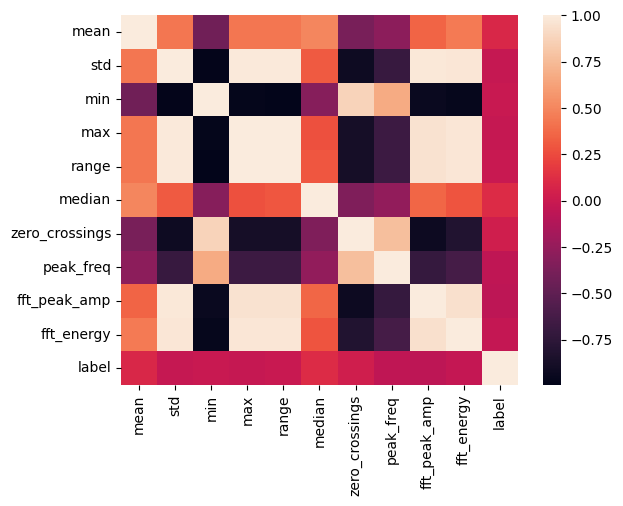

In [3]:
def extract_features(sig):
    sig = np.array(sig)
    if len(sig) == 0:
        return pd.Series(dtype=float)

    # Zeitbereich
    mean = np.mean(sig)
    std = np.std(sig)
    min_val = np.min(sig)
    max_val = np.max(sig)
    value_range = max_val - min_val
    median = np.median(sig)
    zero_crossings = ((sig[:-1] * sig[1:]) < 0).sum()

    # Frequenzbereich
    fft_vals = np.fft.rfft(sig)
    fft_freqs = np.fft.rfftfreq(len(sig), d=1)
    fft_power = np.abs(fft_vals)
    fft_energy = np.sum(fft_power ** 2)

    if len(fft_power) > 1:
        peak_freq = fft_freqs[np.argmax(fft_power[1:]) + 1]
        amp_peak = np.max(fft_power[1:])
    else:
        peak_freq = 0
        amp_peak = 0

    return pd.Series({
        "mean": mean,
        "std": std,
        "min": min_val,
        "max": max_val,
        "range": value_range,
        "median": median,
        "zero_crossings": zero_crossings,
        "peak_freq": peak_freq,
        "fft_peak_amp": amp_peak,
        "fft_energy": fft_energy
    })

# Anwendung auf das DataFrame
features = df["drop_oscillation"].apply(extract_features)
features["label"] = df["label"].values

# Fehlende Werte prüfen und entfernen (Sicherheit)
features.dropna(inplace=True)

# Korrelation der Features visualisieren
sns.heatmap(features.corr())

# Vorschau
features.head()

### Feature-Visualisierung

Zur qualitativen Analyse wurden zwei Beispielsignale (defekt / nicht defekt) gegenübergestellt.  
Dies erlaubt eine erste visuelle Einschätzung möglicher Unterschiede in Schwingungsverlauf, Amplitude oder Streuung.

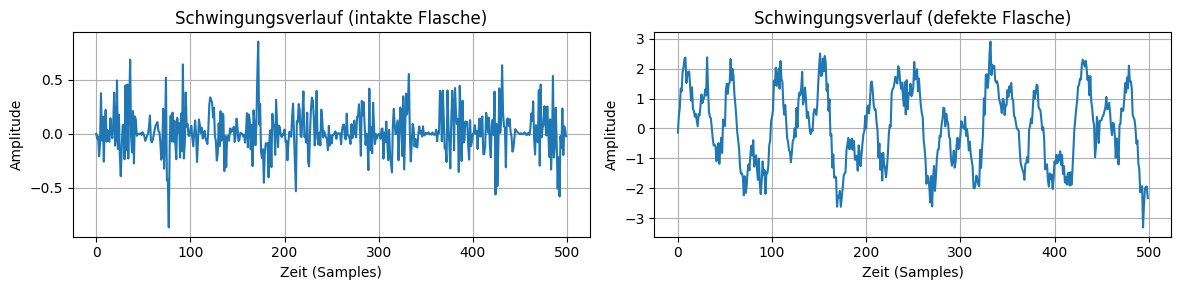

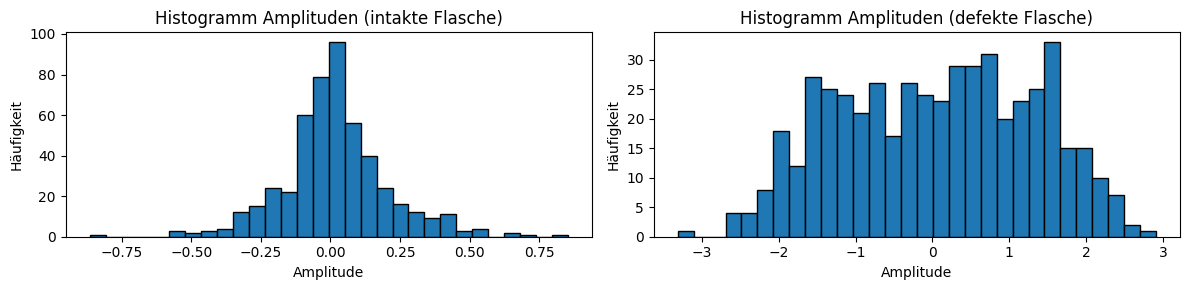

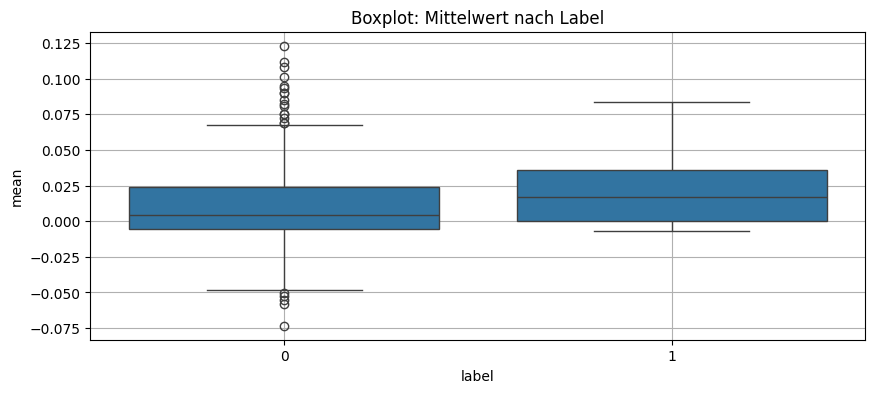

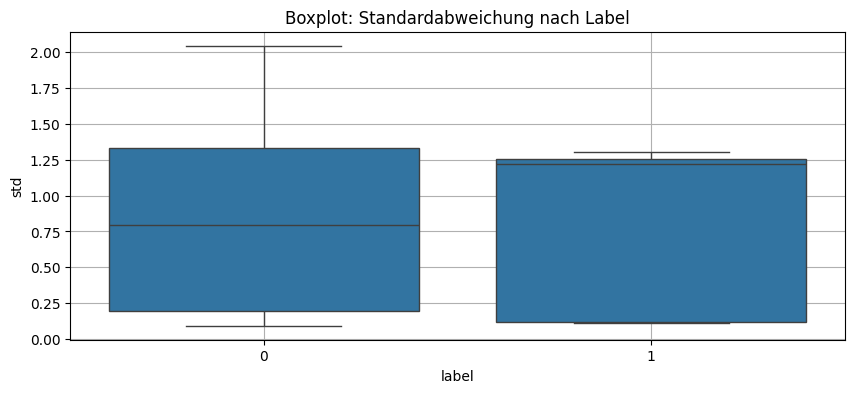

In [4]:
# Zwei Beispielsignale je Klasse
sig_ok = df[df["label"] == 0]["drop_oscillation"].iloc[0]
sig_def = df[df["label"] == 1]["drop_oscillation"].iloc[0]

# Zeitreihenplot nebeneinander
plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
plt.plot(sig_ok)
plt.title("Schwingungsverlauf (intakte Flasche)")
plt.xlabel("Zeit (Samples)")
plt.ylabel("Amplitude")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(sig_def)
plt.title("Schwingungsverlauf (defekte Flasche)")
plt.xlabel("Zeit (Samples)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()

# Histogramme der Amplituden
plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
plt.hist(sig_ok, bins=30, edgecolor='k')
plt.title("Histogramm Amplituden (intakte Flasche)")
plt.xlabel("Amplitude")
plt.ylabel("Häufigkeit")

plt.subplot(1, 2, 2)
plt.hist(sig_def, bins=30, edgecolor='k')
plt.title("Histogramm Amplituden (defekte Flasche)")
plt.xlabel("Amplitude")
plt.ylabel("Häufigkeit")
plt.tight_layout()
plt.show()

# Boxplots über alle Daten für Mittelwert und Standardabweichung
plt.figure(figsize=(10, 4))
sns.boxplot(data=features, x="label", y="mean")
plt.title("Boxplot: Mittelwert nach Label")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
sns.boxplot(data=features, x="label", y="std")
plt.title("Boxplot: Standardabweichung nach Label")
plt.grid(True)
plt.show()

### Definition der Feature-Sets

Zur Modellbewertung wurden vier Feature-Sets gebildet:

1. **time_only** – nur zeitbasierte Merkmale
2. **frequency_only** – nur FFT-Merkmale
3. **combo** – kombinierte, ausgewählte Features
4. **full** – alle verfügbaren Features

Diese Varianten erlauben eine gezielte Bewertung der Informationsdichte einzelner Merkmalsgruppen.

In [5]:
# Alle verfügbaren Features (ohne Label)
all_features = features.columns.drop("label")

# Feature-Sets definieren
feature_sets = {
    "time_only": ["mean", "std", "min", "max", "range", "median", "zero_crossings"],
    "frequency_only": ["peak_freq", "fft_peak_amp", "fft_energy"],
    "combo": ["mean", "std", "peak_freq", "fft_peak_amp"],
    "full": list(all_features)
}

### Datenaufbereitung je Feature-Set und Datenaufteilung (Training und Test)

Die Daten wurden in Trainings- und Testsets aufgeteilt (80/20), wobei das Trainingsset zusätzlich unter Berücksichtigung der Klassenverteilung unter-sampled wurde (`frac = 0.6`). Dadurch konnte ein starkes Klassenungleichgewicht (ca. 10 % defekt) entschärft werden, ohne die Testdaten künstlich zu verändern.

Zusätzlich wurden bei Modellen wie `LogisticRegression` und `kNN` die Daten standardisiert, da diese Modelle sensibel auf Skalierung reagieren.

In [6]:
prepared_data = {}

for name, feature_list in feature_sets.items():
    X = features[feature_list]
    y = features["label"]

    # Step 1: Ganz normaler Split (Testset bleibt unangetastet)
    X_train_full, X_test, y_train_full, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # Step 2: Trainingsdaten in Defekte / Nicht-Defekte trennen
    X_train_full = X_train_full.reset_index(drop=True)
    y_train_full = y_train_full.reset_index(drop=True)

    df_train = X_train_full.copy()
    df_train["label"] = y_train_full

    cracked = df_train[df_train["label"] == 1]
    not_cracked = df_train[df_train["label"] == 0]

    # Trainingsdaten (intakte Flaschen) unter-samplen
    not_cracked_sampled = not_cracked.sample(frac=0.6, random_state=42)

    # Kombinieren & mischen
    balanced_train = pd.concat([cracked, not_cracked_sampled]).sample(frac=1, random_state=42)
    X_train = balanced_train.drop(columns="label")
    y_train = balanced_train["label"]

    # Skalierung
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Speichern
    prepared_data[name] = {
        "X_train_raw": X_train,
        "X_test_raw": X_test,
        "X_train_scaled": X_train_scaled,
        "X_test_scaled": X_test_scaled,
        "y_train": y_train.reset_index(drop=True),
        "y_test": y_test.reset_index(drop=True)
    }

### Vergleich verschiedener Modelle

Für die Klassifikation wurden folgende Modelle verglichen:

- `LogisticRegression` mit *class_weight='balanced'* und *solver='liblinear'*
- `kNN` mit *n_neighbors=4* und *weights='uniform'*
- `DecisionTreeClassifier` mit *max_depth=3*

Jedes Modell wurde mit den verschiedenen Feature-Sets trainiert und evaluiert.  
Für die Auswahl des besten Modells und des entsprechenden Feature-Sets wurden die F1-Scores miteinander verglichen. 

Das beste Modell ist der `DecisionTreeClassifier` mit dem Feature-Set `frequency_only`.

Noch bessere F1-Scores würden durch weitere Verringerung des Klassenungleichgewichts (optimal bei `frac = 0.3`) erzielt,  
jedoch würden dadurch die Testdaten stark reduziert, was die Aussagekraft der Ergebnisse beeinträchtigen könnte.

In [7]:
# Modellkonfiguration
model_configs = {
    "LogisticRegression": {
        "model": LogisticRegression(max_iter=1000, solver='liblinear', class_weight='balanced'),
        "use_scaled": True
    },
    "kNN": {
        "model": KNeighborsClassifier(n_neighbors=4, weights='uniform'),
        "use_scaled": True
    },
    "DecisionTree": {
        "model": DecisionTreeClassifier(random_state=42, max_depth=3),
        "use_scaled": False
    }
}

# Ergebnisliste
results = []

# Schleife: Modell x Feature-Set
for model_name, config in model_configs.items():
    for feat_name, data in prepared_data.items():
        # Richtige Daten holen (skaliert oder unskaliert)
        X_train = data["X_train_scaled"] if config["use_scaled"] else data["X_train_raw"]
        X_test = data["X_test_scaled"] if config["use_scaled"] else data["X_test_raw"]
        y_train = data["y_train"]
        y_test = data["y_test"]

        # Modell kopieren & trainieren
        clf = config["model"]
        clf.fit(X_train, y_train)

        # Vorhersage & Bewertung
        y_pred_train = clf.predict(X_train)
        y_pred_test = clf.predict(X_test)
        f1_train = f1_score(y_train, y_pred_train)
        f1_test = f1_score(y_test, y_pred_test)

        # Ergebnis speichern
        results.append({
            "Model": model_name,
            "Feature_Set": feat_name,
            "F1_Train": f1_train,
            "F1_Test": f1_test
        })

# In DataFrame umwandeln
results_df = pd.DataFrame(results)
results_df.sort_values(by=["F1_Test"], ascending=False).reset_index(drop=True)

,Model,Feature_Set,F1_Train,F1_Test
0,DecisionTree,frequency_only,0.972973,0.727273
1,kNN,time_only,0.800000,0.666667
2,DecisionTree,full,0.972973,0.600000
3,DecisionTree,time_only,0.918919,0.600000
4,kNN,combo,0.750000,0.500000
5,DecisionTree,combo,0.782609,0.500000
6,kNN,full,0.823529,0.444444
7,kNN,frequency_only,0.812500,0.400000
8,LogisticRegression,full,0.463768,0.347826
9,LogisticRegression,time_only,0.318182,0.266667


### Detail-Analyse bestes Modell

Das beste Modell – ein Decision Tree auf Basis der frequenzbasierten Features – wurde abschließend detailliert untersucht:

- **Confusion Matrix** zur Fehlerverteilung
- **ROC-Kurve & AUC** zur Schwellenbewertung
- **Klassifikationsbericht** (F1, Precision, Recall)
- **Feature Importance** zur Modellinterpretation

Die ROC-Kurve zeigte stufenförmige Übergänge, was typisch für Decision Trees mit wenigen Blattknoten ist. AUC = 0.877 unterstreicht die gute Modellqualität.

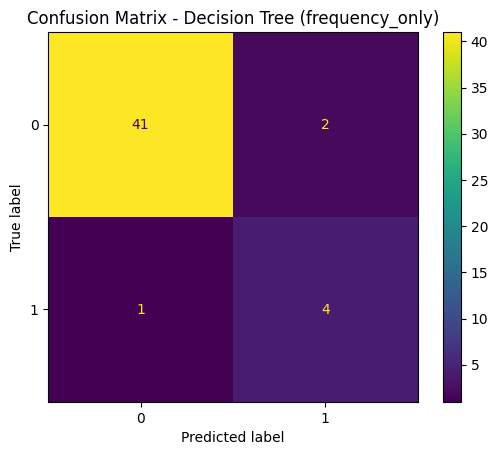

Klassifikationsbericht:
              precision    recall  f1-score   support

           0      0.976     0.953     0.965        43
           1      0.667     0.800     0.727         5

    accuracy                          0.938        48
   macro avg      0.821     0.877     0.846        48
weighted avg      0.944     0.938     0.940        48



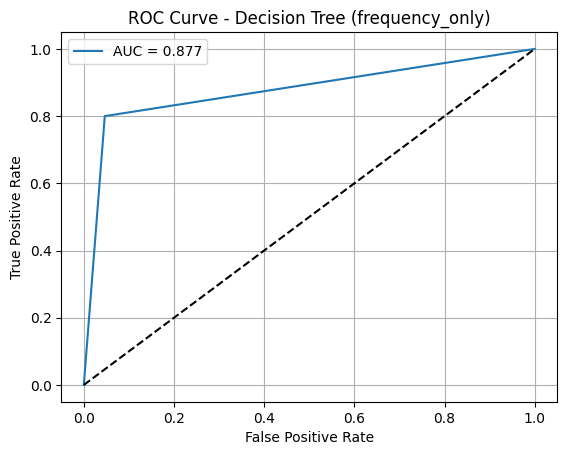

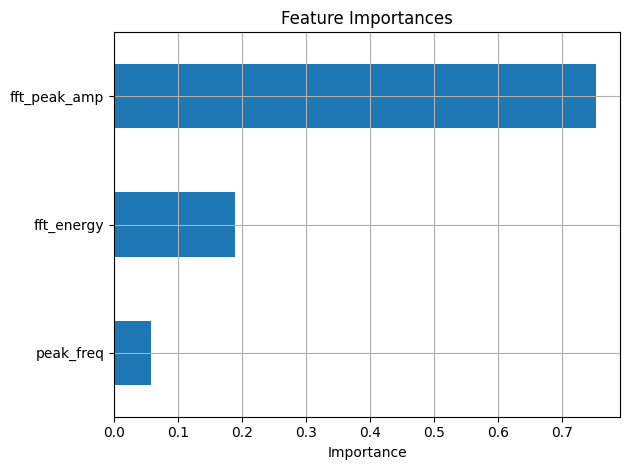

In [8]:
# Bestes Modell: Decision Tree mit frequency_only
data = prepared_data["frequency_only"]
X_train = data["X_train_raw"]
X_test = data["X_test_raw"]
y_train = data["y_train"]
y_test = data["y_test"]

# Modell trainieren
tree = DecisionTreeClassifier(max_depth=3, random_state=42)
tree.fit(X_train, y_train)

# Vorhersage
y_pred = tree.predict(X_test)

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Confusion Matrix - Decision Tree (frequency_only)")
plt.grid(False)
plt.show()

# Klassifikationsbericht
print("Klassifikationsbericht:")
print(classification_report(y_test, y_pred, digits=3))

# ROC-Kurve und AUC
y_score = tree.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_score)
auc = roc_auc_score(y_test, y_score)

plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Decision Tree (frequency_only)")
plt.legend()
plt.grid(True)
plt.show()

# Feature Importances
importances = pd.Series(tree.feature_importances_, index=X_train.columns)
importances.sort_values(ascending=True).plot(kind="barh", title="Feature Importances")
plt.xlabel("Importance")
plt.grid(True)
plt.tight_layout()
plt.show()